# Petals to the Metal : Flower Classification

Nous avons tout d'abord créé un nouvel environnement virtuel dans la version 3.7 de Python pour nous permettre d'acquérir la version 2.1.0 de tensorflow nécessaire à la manipulation des données. Nous avons ensuite installer sur le Prompt les librairies nécessaires.

In [7]:
import os
import sys
os.path.dirname(sys.executable) #Chemin d'accès à notre environnement 

'c:\\users\\sarah\\anaconda3\\envs\\ml_test2'

In [8]:
import numpy as np
import pandas as pd #pour manipuler des tableaux de données(dataframe) avec des étiquettes de variables (colonnes) et d'individus (lignes)
import pandas_tfrecords as pdtfr 
import tensorflow as tf#bibliotheque open source de ML
import cv2#aide dessin avec OpenCV,ajoute titres aux images, classifie images
from PIL import Image,ImageTk # ajoute des capacités de traitement d'image à l'interpréteur Python
import matplotlib.pyplot as plt #tracer graph des dataframes
from resizeimage import resizeimage

from sklearn.model_selection import GridSearchCV
from sklearn import svm, metrics
import io

## Data

In [9]:
os.getcwd() # Chemin d'accès à nos données

'C:\\Users\\sarah\\Desktop\\Cours\\Big_Data_Python'

In [10]:
path="C:\\Users\\sarah\\Desktop\\Cours\\Big_Data_Python\\Project" #Le chemin d'accès aux données

In [11]:
# On prend file to file parcequ'il y a déjà les labels
dtr = pdtfr.tfrecords_to_pandas(path+"\\train\\00-192x192-798.tfrec")
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\01-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\02-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\03-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\04-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\05-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\06-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\07-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\08-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\09-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\10-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\11-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\12-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\13-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\14-192x192-798.tfrec"), ignore_index=True)
dtr = dtr.append(pdtfr.tfrecords_to_pandas(path+"\\train\\15-192x192-783.tfrec"), ignore_index=True)


In [10]:
dtr.columns

Index(['class', 'id', 'image'], dtype='object')

In [10]:
dtr.head() #Les 5 premieres lignes

,class,id,image
0,57,338ab7bac,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1,10,90ffc5d69,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
2,82,76feda65b,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
3,102,416755ace,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
4,94,4b067b390,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...


In [6]:
dtr.shape # on regarde les dimensions de notre dataframe

(12753, 3)

Nous avons 12 753 observations et 3 colonnes ( variables : class,id,image)

In [13]:
count = dtr.groupby('class').count() # On regarde le nombre d'image dans chaque classe 

Nous trouvons qu'il existe 104 classes de fleurs. Par exemple, dans la classe 0, nous avons 272 fleurs. Ensuite, nous allons enlever les petits effectifs des clsses de fleurs car ne permettra assez d'entrainement. De plus, la mémoire vive ne permet pas de travauller avec une grosse base de données


In [14]:
l=list(count["image"])

In [15]:
l_md=np.median(l)
l_md

88.0

Nous voulions retirer toutes les classes ayant un effectif inférieure à la médiane mais nous avons ensuite décidé de garder les groupes avec un effectif supérieur à 190 pour la gestion des données.

In [16]:
class_kept=list()
for i in range(len(count)):
    if l[i]>190:
        class_kept.append(i)
#class_kept

In [17]:
dtr_clean=dtr[dtr["class"].isin(class_kept)]

In [18]:
dtr_clean.groupby('class').count() # Nous nous retrouvons avec 15 classes.

,id,image
class,,
0,272,272
4,703,703
13,263,263
14,227,227
47,261,261
48,422,422
49,563,563
50,201,201
53,460,460


In [19]:
dtr_clean1=dtr[dtr["class"].isin(class_kept)]

In [20]:
dtr_std=dtr[dtr["class"].isin(class_kept)]

In [21]:
#dtr_clean1.iloc[:10] # 10 premieres lignes
dtr_std['image'].shape

(6313,)

Les SVM ne prenant pas en compte les images, il est nécessaire de passer par une fonction transformant nos données en tableau contenant les données de pixels en 1 dimension.

In [22]:
def Bytes_array(data_tfrec): # Convertis bytes en tableau de données
    image = io.BytesIO(data_tfrec) # Decode le string
    image = Image.open(image) #ouvre l'objet retrouvé dans la ligne precedente
    image = np.asarray(image) #transforme en tableau numpy
    image = image.flatten('F') #une image est en 2D, créer une liste 1D
    return image #La fonction nous retourne l'image pixelisée en tableau (on a les valeurs de chaque pixel) 

La fonction Bytes_image nous permet de changer les "tfrecords" en image

In [23]:
def Bytes_image(data_tfrec):# convertis bytes en image
    image = io.BytesIO(data_tfrec) # Decode le string
    image = Image.open(image) #ouvre l'objet retrouvé dans la ligne precedente
    return image

La fonction résolution nous permettre ici de réduire la résolution de nos images à 50x50.

In [24]:
def Resolution(image): # réduire la resolution
    basewidth = 50
    size = image.size[0]
    wpercent = (basewidth / int(size))
    hsize = int((float(image.size[1]) * float(wpercent)))
    image = image.resize((basewidth, hsize), Image.ANTIALIAS)
    return image

La fonction image_array nous permet de passer d'un objet"image" à un tableau contenant les données de pixels en 1 dimension.

In [25]:
def Image_array(image):
    image = np.asarray(image) #transforme en tableau numpy
    image = image.flatten('F')
    return image


La fonction standardisation va nous permettre de standardiser les valeurs des pixels de nos images. Cette fonction nous servira pour les réseaux de neurones ANN qui nécessite des données standardisées.
Pour les SVM et CNN nous induiront des données normalisées.

In [26]:
def Standardisation(image):
    image = (image - np.mean(image)) / np.std(image)
    return image

Dans le code ci-dessous on ajoute une colonne "features" à dtr_clean correspondant à chacune des valeurs des pixels des images et ces pixels sont normalisés. Attention les photos de bases sont en 192x192. Ce tableau sera utilisé pour tenter de faire les PCA.

In [27]:
#avoir une colonne en plus correspondant a chacune des valeurs des pixels et normalisé entre [0,1] 
list_array=list()
for i in range(len(dtr_clean)):
    list_array.append(Bytes_array(dtr_clean.iloc[i]['image'])/255)
dtr_clean['features']=list_array

c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Dans le code suivant on ajoute une colonne "features" à dtr_clean1 correspondant à chacune des valeurs des pixels des images et ces pixels sont normalisés. Les photos de bases sont en 50x50. Ce tableau sera utilisé pour toutes autres applications des SVM.

In [24]:
#avec plus basse resolution et normalisé
list_array=list()
for i in range(len(dtr_clean1)):
    list_array.append(Image_array(Resolution(Bytes_image(dtr_clean1.iloc[i]['image'])))/255)
dtr_clean1["features"]=list_array

c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Dans les lignes suivantes on ajoute une colonne "features" à dtr_std correspondant à chacune des valeurs des pixels des images et ces pixels sont standardisés. Les photos de bases sont en 50x50. Ce tableau sera utilisé pour les ANN.

In [83]:
#Données avec basse résolution standardisé
list_array=list()
for i in range(len(dtr_std)):
    list_array.append(Standardisation(Image_array(Resolution(Bytes_image(dtr_std.iloc[i]['image'])))))
dtr_std["features"]=list_array

c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# SVM 

In [28]:
from sklearn.svm import SVC
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [95]:
#X=tableau/matrices des features
X=list(dtr_clean["features"].values)
#y label, vecteur,list des classes
y=list(np.array(dtr_clean["class"]))
y
#features train et test, labels train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### PCA

On va essayer effectuer une PCA pour diminuer la dimension de nos données

In [96]:
from sklearn.decomposition import PCA 

In [97]:
pca = PCA(n_components = 200) # on essaye aussi avec 300 et 400 et on regarde la variance expliquée

In [98]:
pca.fit(X_train)

PCA(n_components=200)

In [99]:
sum(pca.explained_variance_ratio_)

0.7636422301265682

In [100]:
X_train_reduced = pca.transform(X_train)

In [101]:
X_test_reduced = pca.transform(X_test)

#### Modéliser avec les SVM
L'algorithme de svm offre un choix de fonctions de kernel pour effectuer son traitement.
Fondamentalement, le mappage des données dans une dimension supérieure s'appelle le "kernelling". La fonction mathématique utilisée pour la transformation est connue sous le nom de fonction noyau et peut être de différents types tels que :

    • Linear
    • Polynomial
    • Radial basis fonction (rbf)    
    
Chacune de ces fonctions a ses caractéristiques, ses avantages et ses inconvénients, et son équation, mais comme il est compliqué de savoir quelle fonction performe le mieux selon les données que l’on a, on essaye les fonctions à tour de rôle et on compare les résultats. La fonction par défaut est "rbf".


In [ ]:
### Linear svm avec PCA

In [102]:
lin_svm = svm.SVC(kernel='linear',C=1)

In [103]:
lin_svm.fit(X_train_reduced, y_train)

SVC(C=1, kernel='linear')

In [105]:
#  outputs :
y_pred=lin_svm.predict(X_test_reduced)
#y_pred

In [106]:
#Résultat
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.17      0.24      0.20        71
           4       0.27      0.38      0.32       211
          13       0.15      0.18      0.17        83
          14       0.27      0.33      0.30        78
          47       0.26      0.30      0.28        81
          48       0.28      0.24      0.26       130
          49       0.28      0.23      0.25       172
          50       0.10      0.18      0.13        44
          53       0.29      0.33      0.31       123
          67       0.40      0.33      0.36       248
          68       0.25      0.15      0.19        86
          73       0.35      0.29      0.32       136
          75       0.23      0.22      0.23        90
         102       0.26      0.18      0.21       118
         103       0.29      0.27      0.28       223

    accuracy                           0.27      1894
   macro avg       0.26      0.26      0.25      1894
weighted avg       0.28   

In [107]:
sucess=0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        sucess +=1
sucess/len(y_pred)  #pourcentage de bonne pred

0.2729672650475185

In [ ]:
print(confusion_matrix(y_test, y_pred))

## Linear SVMs avec résolution plus basse

Le PCA mettant beaucoup trop de temps à l'entrainement, et le temps d'exécution du modèle étant très long, nous allons utiliser les données redimensionnées.

In [ ]:
#X=tableau/matrices des features
X=list(dtr_clean1["features"].values)
#y label, vecteur,list des classes
y=list(np.array(dtr_clean1["class"]))
y
#features train et test, labels train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
lin_svm1e3 = svm.SVC(kernel='linear',C=1e3)
#High C values: small number of support vectors

lin_svm1 = svm.SVC(kernel='linear',C=1)
#Low C values: high number of support vectors

C est la pénalité qu'on veut imposer sur les points incorrectement placés dans la classification.

C'est le cout qu'on va donné aux points mal placés, la pénalité, aux points incorrects.

C = 2 par exemple, implique quon donne 2 unité de pénalité à ces points mal placés.


##### Pour C=1e3

In [61]:
lin_svm1e3.fit(X_train, y_train)

SVC(C=1000.0, kernel='linear')

In [62]:
#  outputs :
y_pred=lin_svm1e3.predict(X_test)
#y_pred

In [27]:
#Résultat
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.16      0.24      0.19        76
           4       0.34      0.39      0.37       213
          13       0.10      0.12      0.11        83
          14       0.24      0.27      0.26        74
          45       0.27      0.45      0.34        38
          47       0.21      0.34      0.26        71
          48       0.19      0.21      0.20       129
          49       0.21      0.33      0.25       166
          50       0.19      0.27      0.23        62
          53       0.46      0.36      0.40       133
          67       0.38      0.26      0.30       239
          68       0.19      0.14      0.16        76
          72       0.16      0.11      0.13        54
          73       0.37      0.39      0.38       135
          75       0.22      0.19      0.20        88
          80       0.26      0.12      0.16        58
         102       0.37      0.18      0.24       127
         103       0.32    

In [63]:
sucess=0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        sucess +=1
sucess/len(y_pred)  #pourcentage de bonne pred

0.26582278481012656

In [38]:
print(confusion_matrix(y_test, y_pred))

[[10 16  3  0  0  4  4  1  8  0  0  1  0  5]
 [ 6 49 11  3  5  3  7  1 18  6  0 10  2  9]
 [ 0  6 12  0  0  0 12  2  7  0  3  3  0  3]
 [ 0  5  1 10 14  2  9  0  1  1  0  0  0  0]
 [ 0  7  0  7 25  1  9  3  2  1  1  0  1  0]
 [10  8  3  2  1 20 17  6  5  5  4  2  3  6]
 [ 3 18  2  4 16 14 30 11  7  4  1  0  1  5]
 [ 0  1  8  2  2  3 16 44  1  1  4  0  2  4]
 [ 3 43 11  3  2  8 17  2 41  0  3 15  2  5]
 [13  8  4  1  3  7  5  2  3  5  1  1  0  3]
 [ 4  2  7  1  1  9 14  3  2  2 41  0 14  1]
 [ 2 15  4  2  0  4  5  1 14  1  1 16  0  4]
 [ 2  2  1  2  3  6  6  9  3  0 11  1  9  3]
 [16 21  9  4  7  7 20  2 16  2  7  5  5 37]]


#### Pour C=1e-3 

In [30]:
lin_svm1.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [31]:
#  outputs :
y_pred=lin_svm1.predict(X_test)
#y_pred

In [32]:
#Résultat
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.16      0.24      0.19        76
           4       0.33      0.38      0.36       213
          13       0.10      0.12      0.11        83
          14       0.24      0.27      0.26        74
          45       0.27      0.42      0.33        38
          47       0.21      0.34      0.26        71
          48       0.19      0.21      0.20       129
          49       0.22      0.33      0.26       166
          50       0.20      0.27      0.23        62
          53       0.47      0.38      0.42       133
          67       0.38      0.26      0.31       239
          68       0.20      0.16      0.18        76
          72       0.17      0.11      0.13        54
          73       0.37      0.39      0.38       135
          75       0.22      0.19      0.20        88
          80       0.23      0.10      0.14        58
         102       0.36      0.19      0.25       127
         103       0.32    

In [33]:
sucess=0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        sucess +=1
sucess/len(y_pred)  #pourcentage de bonne pred

0.2693437806072478

In [34]:
print(confusion_matrix(y_test, y_pred))

[[18  9  2  1  0  1  3  6  3  1  7  2  2  4  2  0  1 14]
 [ 6 82 11 10  0  6 10 19  3  0 31  9  1  2  8  0  1 14]
 [ 0 18 10  1  0  4  8 18  6  2  6  0  0  1  3  0  1  5]
 [ 0  7  0 20  0 23  1  7  0  4  3  2  0  1  0  1  0  5]
 [ 0  1  0  1 16  2  1  3  1  6  0  0  0  5  0  0  0  2]
 [ 1  6  0 14  3 24  1 10  0  1  2  2  0  2  1  1  2  1]
 [ 6  2  6  3  3  2 27 23 10  9  3  6  7  2  1  6  5  8]
 [ 9 10 11  7 10 21 12 54  3 11  3  1  0  5  1  1  4  3]
 [ 6  2  4  0  3  0  6  3 17  0  1  0  1 14  3  0  1  1]
 [ 0  0  8  7 12 13 11 16  0 51  3  0  0  2  0  0  4  6]
 [16 53 15  1  0  3  9 14  9  1 62  3  2  3 33  0  3 12]
 [13 11  5  4  0  0  6  7  1  2  3 12  1  0  0  0  3  8]
 [ 5  1  2  2  0  2  6  4  4  0  5  1  6  9  0  2  1  4]
 [ 3  2  2  1  3  0 11  8 10  9  5  2  7 52  0  5  8  7]
 [ 6 13  7  3  0  2  5  3  3  1  9  1  2  3 17  0  2 11]
 [ 2  0  0  0  1  4  6 12  2  0  1  4  2  9  0  6  4  5]
 [ 2  6  7  2  8  2 12 13  5  9  3  4  0 22  0  3 24  5]
 [19 24 13  5  1  8  9 30  9  2

#### Classification non linéaire

* Un noyau linéaire produira une limite de classification linéaire. Ne nécessite pas trop de données.
* Un noyau polynomial, produira une limite de classification sous forme de polynomes; On choisit le degré.
* La fonction 'rbf', la fonction de base radiale, c'est-à-dire le noyau gaussien, détermine la limite de classification en fonction de la distance de chaque vecteur de support. C'est la méthode la plus flexible, mais elle nécessite également le plus de données.

### Svm polynomial

In [53]:
svm_poly = svm.SVC(kernel='poly', degree=2)

In [54]:
svm_poly.fit(X_train, y_train)

SVC(degree=2, kernel='poly')

In [55]:
#  outputs :
y_pred=svm_poly.predict(X_test)
#y_pred

In [56]:
#Résultat
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.25      0.22      0.23        76
           4       0.33      0.50      0.40       213
          13       0.19      0.17      0.18        83
          14       0.29      0.16      0.21        74
          45       0.43      0.53      0.48        38
          47       0.22      0.31      0.26        71
          48       0.29      0.21      0.24       129
          49       0.26      0.33      0.29       166
          50       0.41      0.26      0.32        62
          53       0.53      0.52      0.53       133
          67       0.45      0.46      0.45       239
          68       0.24      0.12      0.16        76
          72       0.32      0.19      0.24        54
          73       0.40      0.42      0.41       135
          75       0.40      0.19      0.26        88
          80       0.48      0.17      0.25        58
         102       0.45      0.24      0.31       127
         103       0.27    

In [57]:
sucess=0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        sucess +=1
sucess/len(y_pred)  #pourcentage de bonne pred

0.3393731635651322

In [96]:
print(confusion_matrix(y_test, y_pred))

[[16  0  0]
 [ 0  3  0]
 [ 1  0  0]]


### Svm gaussien

In [58]:
'''
Kernel coefficient for ‘rbd’, ‘poly’, et ‘sigmoid’.
      Current defaut is ‘auto’ wich uses (1/n_features)
      if ``gamma=’scale’``is passed then it uses 1/(n_features*X_var())
      as value of gamma.
'''

svm_gaussien_auto = svm.SVC(kernel='rbf', C=1,gamma='auto') #auto
svm_gaussien_scale = svm.SVC(kernel='rbf', C=1,gamma='scale')#scale

A noter que gamma correspond à la distribution de la fonction gaussien utilisé pour la projection des données dans l'espace de dimension supérieure.

In [67]:
svm_gaussien_auto.fit(X_train, y_train)

SVC(C=1, gamma='auto')

In [68]:
#  outputs :
y_pred=svm_gaussien_auto.predict(X_test)
#y_pred

In [61]:
#Résultat
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           4       0.33      0.48      0.39       213
          13       0.00      0.00      0.00        83
          14       0.00      0.00      0.00        74
          45       0.00      0.00      0.00        38
          47       0.67      0.08      0.15        71
          48       0.27      0.26      0.26       129
          49       0.25      0.31      0.27       166
          50       0.00      0.00      0.00        62
          53       0.45      0.51      0.48       133
          67       0.28      0.53      0.37       239
          68       0.00      0.00      0.00        76
          72       0.00      0.00      0.00        54
          73       0.38      0.38      0.38       135
          75       0.00      0.00      0.00        88
          80       0.00      0.00      0.00        58
         102       0.41      0.09      0.14       127
         103       0.17    

c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
sucess=0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        sucess +=1
sucess/len(y_pred)  #pourcentage de bonne pred

0.27375122428991183

In [63]:
print(confusion_matrix(y_test, y_pred))

[[  0   6   0   0   0   0  14   1   0   2  20   0   0   1   0   0   0  32]
 [  0 103   0   0   0   0   1   3   0   0  54   0   0   0   0   0   0  52]
 [  0  19   0   0   0   0   0   1   0   2  38   0   0   2   0   0   1  20]
 [  0  28   0   0   0   1   0  15   0   4   0   0   0   0   0   0   0  26]
 [  0   0   0   0   0   0   0  17   0  10   2   0   0   3   0   0   0   6]
 [  0  20   0   0   0   6   0  23   0   1   1   0   0   1   0   0   1  18]
 [  0   5   0   0   0   0  33  13   0  11  20   0   0   2   0   0   0  45]
 [  0   9   0   0   0   2  11  51   0  17  20   0   0   2   0   0   2  52]
 [  0   1   0   0   0   0   4   2   0   0  11   0   0  27   0   0   1  16]
 [  0   7   0   0   0   0   3  23   0  68   4   0   0   0   0   0   2  26]
 [  0  47   0   0   0   0   3   3   0   1 127   0   0   1   0   0   3  54]
 [  0   6   0   0   0   0   5   0   0   0  18   0   0   0   0   0   0  47]
 [  0   2   0   0   0   0   8   6   0   1  10   0   0   7   0   0   1  19]
 [  0   1   0   0   0   0

On regarde avec scale

In [64]:
svm_gaussien_scale.fit(X_train, y_train)

SVC(C=1)

In [65]:
#  outputs :
y_pred=svm_gaussien_scale.predict(X_test)
#y_pred

In [107]:
#Résultat
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           4       0.94      1.00      0.97        16
          45       1.00      1.00      1.00         3
          61       0.00      0.00      0.00         1

    accuracy                           0.95        20
   macro avg       0.65      0.67      0.66        20
weighted avg       0.90      0.95      0.93        20



c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
sucess=0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        sucess +=1
sucess/len(y_pred)  #pourcentage de bonne pred

0.3721841332027424

In [109]:
print(confusion_matrix(y_test, y_pred))

[[16  0  0]
 [ 0  3  0]
 [ 1  0  0]]


### RBF optimisé : C et gamma

Dans le code ci-dessous, nous recherchons les paramètres C et gamma tel que le SVM Gaussien soit optimisé, c'est-à-dire que le score de prédiction soit au plus haut et l'erreur quadratique minimisée.

In [ ]:
# Svm gaussien GridSearch 

import seaborn as sns

grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']}

svm_gaussien = svm.SVC(max_iter = 100)
grid_search = GridSearchCV(svm_gaussien, param_grid = grid, refit = True)
svm_gaussien_fit = grid_search.fit(X_train, y_train)


pred_gaussien = grid_search.predict(X_test)
print(metrics.classification_report(pred_gaussien, y_test))


c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

In [ ]:
sucess=0
for i in range(len(y_pred)):
    if pred_gaussien[i]==y_test[i]:
        sucess +=1
sucess/len(pred_gaussien)  #pourcentage de bonne pred

On va visualisé ci-dessous l'effet de certaines combinaisons de gamma et de C sur le score de prédiction moyen.

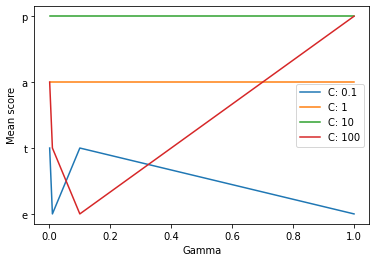

In [30]:
# C, gamma, erreur graphique
C = [0.1, 1, 10, 100]
gamma = [1, 0.1, 0.01, 0.001]

scores = [x[1] for x in grid_search.cv_results_]
scores = np.array(scores).reshape(len(C), len(gamma))

for ind, i in enumerate(C):
    plt.plot(gamma, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()

# Réseaux de neurones ANN (Artifical Neurone Network)
On va créer notre réseau de neurone de part la fonction "keras" de la librairie tensorflow

In [29]:
from tensorflow import keras

In [74]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split déjà importé

In [84]:
#Les données

#X=tableau/matrices des features
X=np.asarray(list(dtr_std["features"].values))
#y label, vecteur,list des classes
y=np.asarray(list(np.array(dtr_std["class"])))


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
print(X_train.shape,X_test.shape)

(4419, 7500) (1894, 7500)


## Construction de réseaux de neurones

In [88]:
#Création du réseau de neurones
ann_model=tf.keras.models.Sequential()# Sequential est le modele de réseaux de neurones qu'on tente d'utiliser ici

Ici nous ajoutons une couche intermédiaire(cachée).

In [89]:
#On va maintenant ajouter une couche, la premiere couche cachée
ann_model.add(tf.keras.layers.Dense(units=50,activation='relu',input_dim=7500)) # on importe la couche de type "Dense"

In [81]:
count.shape

(104, 2)

In [90]:
# On doit aussi rajouter la couche de sortie avec fonction d'activation " sigmoid"
ann_model.add(tf.keras.layers.Dense(units=104,activation='sigmoid'))

Maintenant nous devons compiler ces deux fonctions mais aussi rajouter la fonction "Coût" (la fonction 'loss') qui va nous permettre de "mettre a jour " les poids au fur et à mesure de l'apprentissage.

In [91]:
ann_model.compile(optimizer='sgd',loss="sparse_categorical_crossentropy",metrics=['accuracy'])# optimizer = comment les poids vont être mis à jour
#metrics= calculer la précision de notre model (cest a dire combien de fois on se trompe, on ne commet pas d'erreur)

In [99]:
#petite synthèse de ce qu'on vient de construire 
ann_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8)                 60008     
_________________________________________________________________
dense_6 (Dense)              (None, 104)               936       
Total params: 60,944
Trainable params: 60,944
Non-trainable params: 0
_________________________________________________________________


Nous allons maintenant entraîner notre réseau de neurones. C'est-à-dire affecter les poids adéquats pour effectuer la prévision la plus correct possible.

Nous devons spécifier 2 choses : 

Lorsque je mets à jour les poids est ce que je fais passer toute la base de données ou quelques éléments ?
Si je veux faire passer toute la base de données je ne mets rien, si je veux faire passer quelques éléments je vais mettre ce que l'on appelle 'batch_size'. Ici nous si nous spécifions par exemple batch_size = 10, nous faisons passer 10 échantillons et mettons les poids à jour.

A noter que le fait de faire passer toutes les données prend beaucoup de temps.

epochs = combien de fois je fais passer la base de données pour entrainer mon modele. Nous pouvons mettre un grand nombre car avec epoch on essaye de calculer la metric et la fonction de perte ou bien la fonction de cout.

In [92]:
history=ann_model.fit(X_train,y_train,epochs=100)


Train on 4419 samples
Epoch 1/100
4419/4419 [==============================] - 1s 300us/sample - loss: 4.0026 - accuracy: 0.0407
Epoch 2/100
4419/4419 [==============================] - 1s 147us/sample - loss: 3.3554 - accuracy: 0.0482
Epoch 3/100
4419/4419 [==============================] - 1s 164us/sample - loss: 3.0900 - accuracy: 0.0554
Epoch 4/100
4419/4419 [==============================] - 1s 156us/sample - loss: 3.0256 - accuracy: 0.0586
Epoch 5/100
4419/4419 [==============================] - 1s 149us/sample - loss: 2.9622 - accuracy: 0.0618
Epoch 6/100
4419/4419 [==============================] - 1s 148us/sample - loss: 2.8615 - accuracy: 0.0683
Epoch 7/100
4419/4419 [==============================] - 1s 152us/sample - loss: 2.8273 - accuracy: 0.0706
Epoch 8/100
4419/4419 [==============================] - 1s 150us/sample - loss: 2.7753 - accuracy: 0.0751
Epoch 9/100
4419/4419 [==============================] - 1s 150us/sample - loss: 2.7048 - accuracy: 0.0808
Epoch 10/100
44

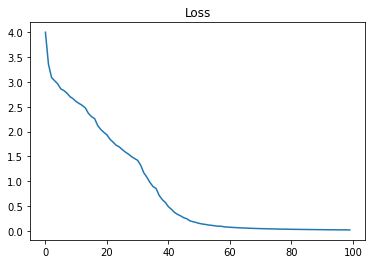

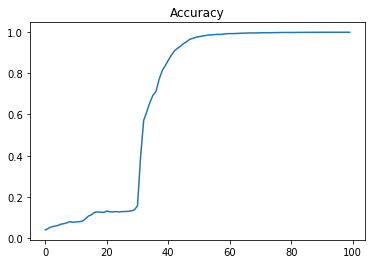

In [93]:
loss_curve=history.history["loss"]
acc_curve = history.history["accuracy"]
plt.plot(loss_curve)
plt.title("Loss")
plt.show()

plt.plot(acc_curve)
plt.title("Accuracy")
plt.show()

In [107]:
test_loss,test_accuracy=ann_model.evaluate(X_test,y_test)

1263/1263 [==============================] - 1s 526us/sample - loss: 4.3559 - accuracy: 0.2874


In [108]:
print(f'Test accuracy {test_accuracy} et Test loss {test_loss}')

Test accuracy 0.2874109148979187 et Test loss 4.355865567238295


# CNN ( Convolutional Neural Network)

Les CNN sont applicaples sur des tableaux avec des données d'images non applaties comme on a pu le faire pour les autres modèles. Nous gardons donc nos format d'images en 50x50x3.

In [30]:
def Image_array2D(image):
    image = np.asarray(image) #transforme en tableau numpy
    return image

In [31]:
dtr_2D=dtr[dtr["class"].isin(class_kept)]

In [32]:
list_array=list()
for i in range(len(dtr_2D)):
    list_array.append(Image_array2D(Resolution(Bytes_image(dtr_2D.iloc[i]['image']))))
dtr_2D["features"]=list_array

c:\users\sarah\anaconda3\envs\ml_test2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
X=np.asarray(list(dtr_2D["features"].values))
#y label, vecteur,list des classes
y=np.asarray(list(np.array(dtr_2D["class"])))


In [135]:
print("shape features",X.shape)
print("shape label",y.shape)

shape features (6313, 50, 50, 3)
shape label (6313,)


#### Visualisation de quelques images

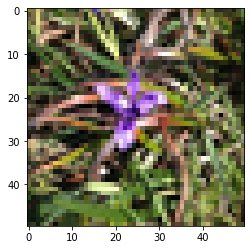

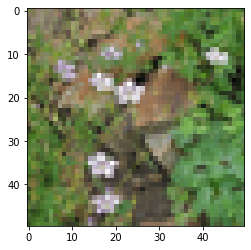

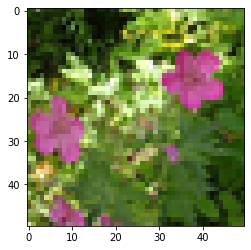

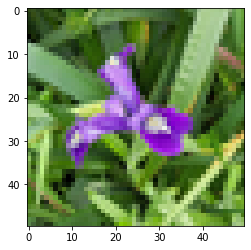

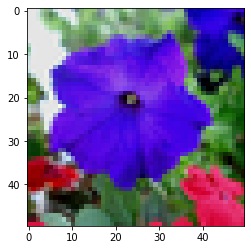

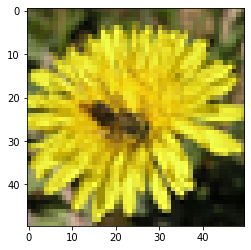

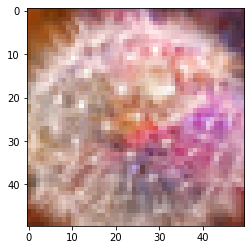

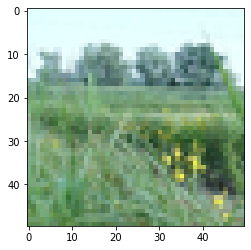

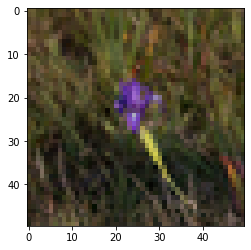

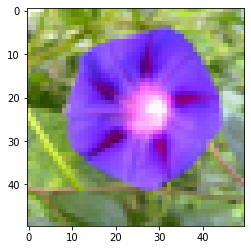

In [136]:
from random import randint
# on regarde 10 images random
for a in [randint(0,len(y)) for _ in range(10)]:
    plt.imshow(X[a])
    plt.show()

### Création des modèles 

Nous allons maintenant tenter de faire un simple réseau convolutif à 3 couches de convolutions. L'idée d'une couche de convolution est de détecter des formes récurrentes retrouvées dans les différentes images. Dans le modèle que nous créons, la première couche recherche jusqu'à 128 formes de tailles 3x3, puis avec ces formes nous en construisons 64 autres de tailles 5x5 pour finir avec la troisième couche qui construit 32 autres formes de taille 7x7.



In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
X_train=X_train/255.0
X_test=X_test/255.0

In [139]:
#creation modele
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="valid", input_shape=(50, 50, 3)),
    keras.layers.Conv2D(filters=64,  kernel_size=(5, 5), activation="relu", padding="valid"),
    keras.layers.Conv2D(filters=32,  kernel_size=(7, 7), activation="relu", padding="valid"),
    keras.layers.Flatten(),
    keras.layers.Dense(104, activation="softmax")])

In [140]:
#Compilation du réseau de convolution
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

In [141]:
history = model.fit(X_train, y_train, epochs=20,batch_size=100)

Train on 4419 samples
Epoch 1/20
 200/4419 [>.............................] - ETA: 2:48 - loss: 4.6397 - sparse_categorical_accuracy: 0.0000e+00

KeyboardInterrupt: 

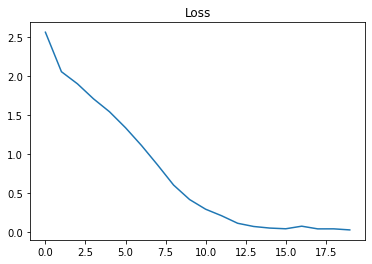

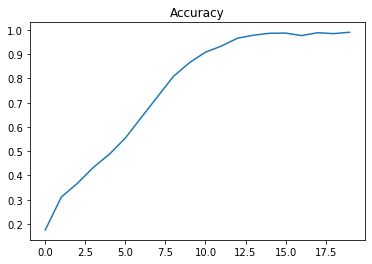

In [78]:
loss_curve=history.history["loss"]
acc_curve = history.history["sparse_categorical_accuracy"]
plt.plot(loss_curve)
plt.title("Loss")
plt.show()

plt.plot(acc_curve)
plt.title("Accuracy")
plt.show()

In [80]:
test_loss,test_accuracy=model.evaluate(X_test,y_test)

1894/1894 [==============================] - 11s 6ms/sample - loss: 6.6062 - sparse_categorical_accuracy: 0.3733


In [81]:
print(f'Test accuracy {test_accuracy} et Test loss {test_loss}')

Test accuracy 0.3732840418815613 et Test loss 6.606189904016578


Nous tentons maintenant d'introduire ce qu'on appelle la couche "pooling" permettant de réduire la taille de l'image , donc de se concentrer sur des formes de plus en plus grande et d'effacer les petits détails qui ne sont pas forcément nécessaire à l'interprétation.

In [146]:
#creation modele
model1 = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="valid", input_shape=(50, 50, 3)),
    keras.layers.Conv2D(filters=64,  kernel_size=(5, 5), activation="relu", padding="valid"),
    keras.layers.Conv2D(filters=32,  kernel_size=(7, 7), activation="relu", padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(104, activation="softmax")])

In [147]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

In [148]:
history = model1.fit(X_train, y_train, epochs=30,batch_size=100)

Train on 4419 samples
Epoch 1/30
4419/4419 [==============================] - 146s 33ms/sample - loss: 2.6736 - sparse_categorical_accuracy: 0.1541
Epoch 2/30
4419/4419 [==============================] - 154s 35ms/sample - loss: 2.1122 - sparse_categorical_accuracy: 0.2906
Epoch 3/30
4419/4419 [==============================] - 151s 34ms/sample - loss: 1.8979 - sparse_categorical_accuracy: 0.3600
Epoch 4/30
4419/4419 [==============================] - 149s 34ms/sample - loss: 1.7719 - sparse_categorical_accuracy: 0.4046
Epoch 5/30
4419/4419 [==============================] - 149s 34ms/sample - loss: 1.6452 - sparse_categorical_accuracy: 0.4537
Epoch 6/30
4419/4419 [==============================] - 147s 33ms/sample - loss: 1.4934 - sparse_categorical_accuracy: 0.4931
Epoch 7/30
4419/4419 [==============================] - 153s 35ms/sample - loss: 1.3787 - sparse_categorical_accuracy: 0.5325
Epoch 8/30
4419/4419 [==============================] - 156s 35ms/sample - loss: 1.3057 - sparse

In [150]:
test_loss,test_accuracy=model1.evaluate(X_test,y_test)

1894/1894 [==============================] - 10s 5ms/sample - loss: 4.4910 - sparse_categorical_accuracy: 0.4467


Nous allons maintenant créer un CNN à 5 couches pour ainsi voir si la qualité de précision grandit tout en ajoutant également une couche "MaxPooling2D".

In [36]:
#creation modele
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="valid", input_shape=(50, 50, 3)),
    keras.layers.Conv2D(filters=64,  kernel_size=(5, 5), activation="relu", padding="valid"),
    keras.layers.Conv2D(filters=32,  kernel_size=(7, 7), activation="relu", padding="valid"),
    keras.layers.Conv2D(filters=16,  kernel_size=(9, 9), activation="relu", padding="valid"),
    keras.layers.Conv2D(filters=8,  kernel_size=(12, 12), activation="relu", padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(7, 7)),
    keras.layers.Flatten(),
    keras.layers.Dense(104, activation="softmax")])

In [37]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

In [38]:
history = model2.fit(X_train, y_train, epochs=50,batch_size=100)

Train on 4419 samples
Epoch 1/30
4419/4419 [==============================] - 174s 39ms/sample - loss: 4.2634 - sparse_categorical_accuracy: 0.0776
Epoch 2/30
4419/4419 [==============================] - 171s 39ms/sample - loss: 2.9220 - sparse_categorical_accuracy: 0.1378
Epoch 3/30
4419/4419 [==============================] - 171s 39ms/sample - loss: 2.5141 - sparse_categorical_accuracy: 0.1593
Epoch 4/30
4419/4419 [==============================] - 171s 39ms/sample - loss: 2.4403 - sparse_categorical_accuracy: 0.1697
Epoch 5/30
4419/4419 [==============================] - 171s 39ms/sample - loss: 2.3959 - sparse_categorical_accuracy: 0.1856
Epoch 6/30
4419/4419 [==============================] - 171s 39ms/sample - loss: 2.3204 - sparse_categorical_accuracy: 0.2120
Epoch 7/30
4419/4419 [==============================] - 171s 39ms/sample - loss: 2.3011 - sparse_categorical_accuracy: 0.2270
Epoch 8/30
4419/4419 [==============================] - 172s 39ms/sample - loss: 2.2103 - sparse

In [39]:
test_loss,test_accuracy=model2.evaluate(X_test,y_test)

1894/1894 [==============================] - 11s 6ms/sample - loss: 1.6795 - sparse_categorical_accuracy: 0.4520


## Comparaison des modeles

In [2]:

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

### Les classifiers

In [4]:

names = ["Linear_SVM", "Polynomial_SVM", "RBF_SVM", "Gaussian_Process",
         "Gradient_Boosting","Neural_Net"]

classifiers = [
    SVC(kernel="linear", C=1),
    SVC(kernel="poly", degree=2, C=1),
    SVC(kernel="rbf", C=10, gamma=0.4),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    MLPClassifier(alpha=1, max_iter=1000)]

### Construire un modèle, appliquer un modèle sur les données de test et enregistrer les scores de précision

In [5]:
#X=tableau/matrices des features
X=list(dtr_clean1["features"].values)
#y label, vecteur,list des classes
y=list(np.array(dtr_clean1["class"]))
y
#features train et test, labels train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

NameError: name 'dtr_clean1' is not defined

In [33]:

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

KeyboardInterrupt: 

In [34]:
scores

[0.1816261879619852,
 0.2787750791974657,
 0.31573389651531153,
 0.13199577613516367,
 0.12143611404435058]

### Analyse de la performance des modeles

#### On crée un dataframe des scores

In [304]:
df = pd.DataFrame()
df['name'] = names
df['score'] = scores
df

,name,score
0,Nearest_Neighbors,0.182154
1,RBF_SVM,0.304646
2,Gradient_Boosting,0.132524


In [306]:
import seaborn as sns

#les couleurs
cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
s

,name,score
0,Nearest_Neighbors,0.182154
1,RBF_SVM,0.304646
2,Gradient_Boosting,0.132524


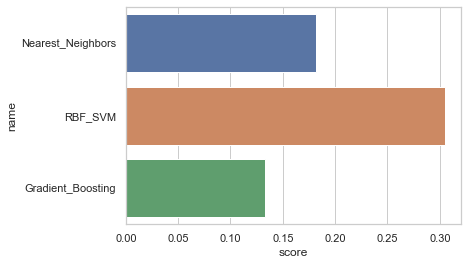

In [307]:
#barplot
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df)